In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind=<Axes: >)` instead of `Series.plot(<Axes: >,)`.

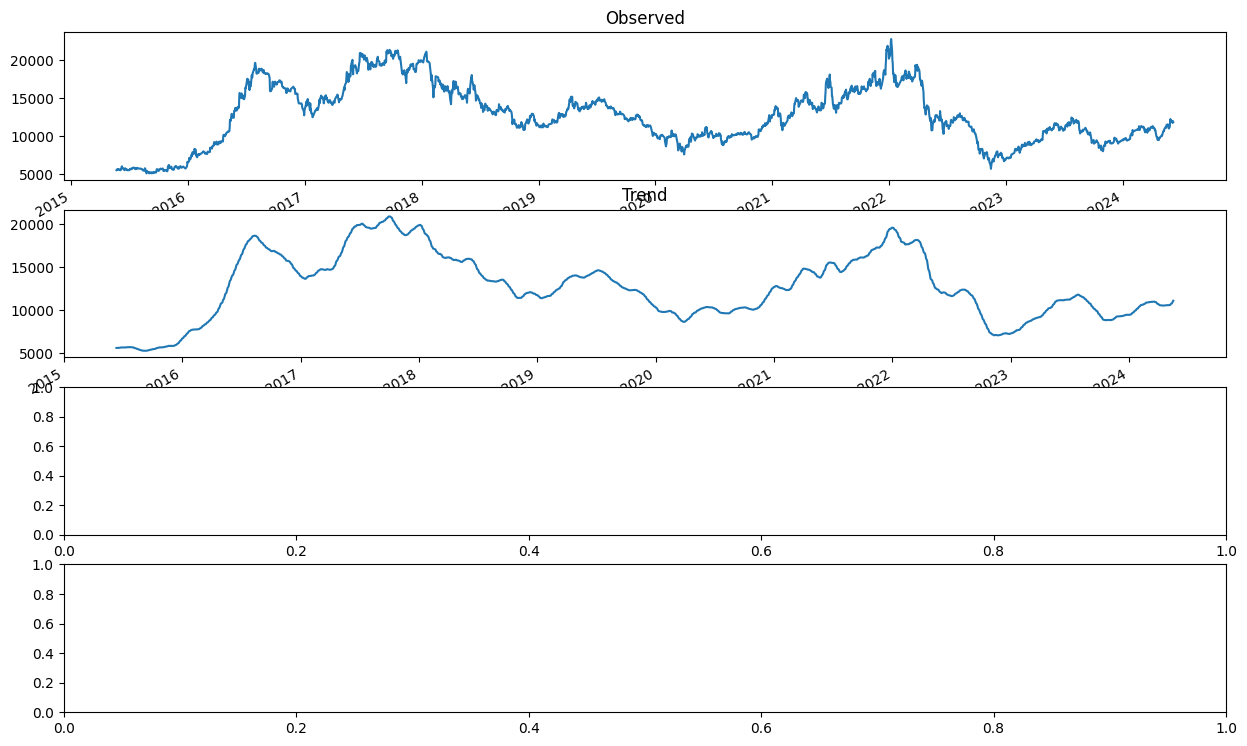

In [6]:

# Load the dataset
file_path = 'D:\\Github anyud\\final\\Data_stock\\processed_stock_data.csv'
stock_data = pd.read_csv(file_path)
# Convert Date column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Sort data by Date for each stock
stock_data = stock_data.sort_values(by=['Stock_Name', 'Date'])

# Function to visualize trend and seasonality
def plot_decomposition(stock_df, stock_name):
    stock_series = stock_df.set_index('Date')['Price']
    result = seasonal_decompose(stock_series, model='additive', period=30)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))
    result.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    result.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    result.seasonal.plot(ax3)
    ax3.set_title('Seasonal')
    result.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    plt.tight_layout()
    plt.suptitle(f'Decomposition of {stock_name} Stock Price', y=1.02)
    plt.show()

# Filter data for one stock (e.g., AAA)
stock_name = 'AAA'
stock_df = stock_data[stock_data['Stock_Name'] == stock_name]

# Plot decomposition
plot_decomposition(stock_df, stock_name)


In [7]:
import os
import joblib
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Directory to save models
model_dir = 'D:\\Github anyud\\final\\my_dir_LSTM'
os.makedirs(model_dir, exist_ok=True)

# Directory to save visualizations
visual_dir = os.path.join(model_dir, 'visuals')
os.makedirs(visual_dir, exist_ok=True)

# Function to train, predict, visualize, and save ARIMA model using auto_arima
def train_predict_visualize_save_arima_models(data, model_dir, train_ratio=0.8):
    stock_names = data['Stock_Name'].unique()
    
    for stock in stock_names:
        stock_df = data[data['Stock_Name'] == stock].set_index('Date')['Price']
        
        # Split data into training and prediction sets
        train_size = int(len(stock_df) * train_ratio)
        train_data, test_data = stock_df[:train_size], stock_df[train_size:]
        
        # Train auto ARIMA model
        model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                                     test='adf', max_p=3, max_q=3,
                                     m=1, d=None, seasonal=True,
                                     start_P=0, D=0, trace=True,
                                     error_action='ignore', 
                                     suppress_warnings=True, 
                                     stepwise=True)
        
        # Save the model
        model_path = os.path.join(model_dir, f'{stock}_autoARIMA.pkl')
        joblib.dump(model_autoARIMA, model_path)
        
        print(f"Auto ARIMA model for {stock} trained and saved successfully.")
        
        # Print model summary
        print(model_autoARIMA.summary())
        
        # Plot diagnostics and save
        diagnostics_path = os.path.join(visual_dir, f'{stock}_diagnostics.png')
        fig = model_autoARIMA.plot_diagnostics(figsize=(15, 8))
        plt.suptitle(f'Diagnostics for {stock}')
        fig.savefig(diagnostics_path)
        plt.close(fig)
        
        # Forecast and plot the results
        n_periods = len(test_data)
        forecast, conf_int = model_autoARIMA.predict(n_periods=n_periods, return_conf_int=True)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_data.index, train_data, label='Training Data')
        plt.plot(test_data.index, test_data, label='Actual Prices')
        plt.plot(test_data.index, forecast, label='Forecasted Prices')
        plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
        plt.title(f'Forecast for {stock}')
        plt.legend()
        
        # Save forecast plot
        forecast_path = os.path.join(visual_dir, f'{stock}_forecast.png')
        plt.savefig(forecast_path)
        plt.close()

# Train, predict, visualize, and save ARIMA models for all stocks
train_predict_visualize_save_arima_models(stock_data, model_dir)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26230.881, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26230.998, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26230.837, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26229.117, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26231.410, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.424 seconds
Auto ARIMA model for AAA trained and saved successfully.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1806
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -13113.559
Date:                Tue, 25 Jun 2024   AIC                          26229.117
Time:                        15:48:05   BIC                          26234.615
Sample:                             0   HQIC                         26231.146
              

In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Đọc dữ liệu
file_path = 'D:\\Github anyud\\final\\Data_stock\\processed_stock_data.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Đảm bảo dữ liệu được sắp xếp theo ngày
data = data.sort_index()

# Lấy danh sách các mã cổ phiếu
stock_symbols = data['Stock_Name'].unique()

# Hàm thực hiện bài kiểm tra ADF
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Trả về giá trị p-value

# Hàm tìm mô hình ARIMA tốt nhất
def find_best_arima_model(data):
    best_aic = float('inf')
    best_order = None
    best_mdl = None
    
    for p in range(0, 6):
        for d in range(0, 3):
            for q in range(0, 6):
                try:
                    tmp_mdl = ARIMA(data, order=(p,d,q)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p,d,q)
                        best_mdl = tmp_mdl
                except: 
                    continue
    return best_order, best_mdl

# Từ điển lưu các mô hình ARIMA
arima_models = {}

for symbol in stock_symbols:
    # Lọc dữ liệu cho mỗi mã cổ phiếu
    stock_data = data[data['Stock_Name'] == symbol]['Price']
    
    # Kiểm tra tính tĩnh và xác định bậc khác biệt hóa
    p_value = adf_test(stock_data)
    d = 0
    if p_value > 0.05:
        stock_data = stock_data.diff().dropna()
        p_value = adf_test(stock_data)
        d = 1
        if p_value > 0.05:
            stock_data = stock_data.diff().dropna()
            p_value = adf_test(stock_data)
            d = 2

    # Tìm mô hình ARIMA tốt nhất
    order, model = find_best_arima_model(stock_data)
    
    # Lưu mô hình
    arima_models[symbol] = model
    
    # In kết quả tóm tắt
    print(f'Mô hình ARIMA tốt nhất cho {symbol} với order {order}:')
    print(model.summary())
    
    # Vẽ biểu đồ chẩn đoán
    model.plot_diagnostics(figsize=(15, 12))
    plt.suptitle(f'Biểu đồ chẩn đoán của mô hình ARIMA cho {symbol}')
    plt.show()
